In [1]:
%matplotlib inline
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from render import *

def test_ok():
    """ If execution gets to this point, print out a happy message """
    try:
        from IPython.display import display_html
        display_html("""<div class="alert alert-success">
        <strong>Tests passed!!</strong>
        </div>""", raw=True)
    except:
        print "Tests passed!!"

# Basic Neural Nets

In this problem set, you'll implement some of the basic functionality of neural nets as well as structure some simple nets of your own. 

## Drawing Lines in Feature Space

Neural networks, at their core, can be thought of as functions that draw regions in feature space. By separating the space of features into sections by drawing decision boundaries, they can be used to classify inputs. 

During the lecture, we focused on how deep convolutional neural networks can classify images, but in this problem set, we will be focusing on very basic, shallow neural nets. Let's take a look at an example. 

Given a simple two-dimentional situation, and using the step function as the activation function for the neurons, what neural net would draw the following line?

y >= 5x + 3

Recall that the step function is as follows: 

<img src="stepFunction.png" width="300" height=auto>

We can rewrite this equation slightly to make it easier to see. 

y - 5x >= 3

Now if we had step function with a threshold (T) value of 3 and we weighted our x input by -5, we'd get our equation!

<img src="example1.png" width="400" height=auto>

Note that we actually only need a single neuron to draw one decision boundary. In general, a neural net can draw one line for every neuron that is directly connected to the inputs. (We call these collective neurons the input layer) So, the neural network below could draw 4 decision boundaries. 

<img src="nnEx.png" width="400" height=auto>


We can combine the regions formed by these decision boundaries using logical operations. 

Let's take a look at AND.

| X | Y | AND(X,Y) 
|:---:|:---:|:---:|
| 0 |0 | 0 |
| 0 |1 | 0 |
| 1 |0 | 0 |
| 1 |1 | 1 |

Assuming binary inputs, this truth table can also be described like this: 

<img src="andGraph.png" width="200" height=auto>

We can draw the following decision boundary and now we have a region that matches our desired output.

<img src="andGraph2.png" width="200" height=auto>

This means we can express this logical operation with a neuron as well! 

<img src="andTotal.png" width="600" height=auto>

One last trick to discuss. As we talked about in lecture, neural nets update their weights via backpropagation to improve the accuracy of the network's output. We want our networks to be able to adjust the activation function's parameters as well, so we are going to express them as normal weights. 

We do this by putting in an additional input, set to be -1 and weight it by our function's parameter. In this case, we are using the step function, so the weight will be the T value. Now our step function will use it's default parameter (T =0), but we have maintained the desired function by adding in this extra weighted input. 

Let's see how our AND neuron changes when we use this thresholding trick. 

<img src="andTotal2.png" width="600" height=auto>


Now we can try and create some neural nets of our own.



## Neural Net API

In [2]:
def step(x):
  return x > 0
  
def sigmoid(x, slope_at_zero=1):
  return 1. / (1 + np.e ** (-4 * slope_at_zero * x))
  
def accuracy(desired_out, out):
  return -.5 * (desired_out - out) ** 2

class Neuron:
  def __init__(self, name, input_weight_pairs):
    self.name = str(name)
    self.weight_dict = {input:weight for (input, weight) in input_weight_pairs}
    self.inputs = [input for (input, weight) in self.weight_dict.items()]
    self.neuron_inputs = [input for input in self.inputs if input == str(input)]
  
  # Recalculate neuron's output based on input neurons most recent outputs and threshold function
  def call(self, output_dict, threshold_function):
    output_dict[self.name] = threshold_function(sum([output_dict.get(input, input) * weight for (input, weight) in self.weight_dict.items()]))
    
  # Retrieve weight for a given input neuron
  def get_weight(self, input):
    return self.weight_dict[input]
  
  # Update weight for a given input neuron
  def update_weight(self, input, new_weight):
    self.weight_dict[input] = new_weight

class NN:
  def __init__(self, inputs, neuron_names, output_neuron, connections):
    self.inputs = list(inputs)
    self.connections = connections
    self.neurons = {name:Neuron(name, [(from_neuron, weight) for (from_neuron, to_neuron, weight) in connections if to_neuron == name]) for name in neuron_names}
    # self.output_neurons = [neuron for neuron in output_neurons if neuron in self.neurons else raise Exception(str(neuron) + ' is an output, but not in neuron list!')]
    if output_neuron not in self.neurons:
      raise Exception(str(neuron) + ' is selected as output neuron, but is not in neuron list!')
    self.output_neuron = output_neuron
    self.top_sorted_neurons = self.top_sort(neuron_names)
  
  def graph(self):
    G = nx.DiGraph()
    G.add_weighted_edges_from([(input, neuron_name, neuron.weight_dict[input]) for (neuron_name, neuron) in self.neurons.items() for input in neuron.inputs])
    display_stn(G)
#     G = nx.DiGraph()
#     G.add_weighted_edges_from([(input, neuron_name, neuron.weight_dict[input]) for (neuron_name, neuron) in self.neurons.items() for input in neuron.inputs])
#     pos=nx.spring_layout(G)
#     nx.draw(G,pos,node_size=1200)
#     labels = nx.get_edge_attributes(G,'weight')
#     nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=16)
#     nx.draw_networkx_labels(G,pos,font_size=16)
#     plt.show()

    
  # returns a topologically sorted list of neuron names in the neural net
  def top_sort(self, neuron_names):
    unsorted_neuron_names = set(neuron_names)
    sorted_neuron_names = []
    valid_inputs = set(self.inputs)
    num_unsorted_neurons = len(unsorted_neuron_names)
    while num_unsorted_neurons > 0:
      for neuron in list(unsorted_neuron_names):
        if all([input in valid_inputs for input in self.neurons[neuron].inputs]):
          sorted_neuron_names.append(neuron)
          valid_inputs.add(neuron)
          unsorted_neuron_names.remove(neuron)
      if len(unsorted_neuron_names) == num_unsorted_neurons:
        raise Exception(str(num_unsorted_neurons) + ' neurons are unreachable or have unreachable inputs!')
      num_unsorted_neurons = len(unsorted_neuron_names)
    return sorted_neuron_names
    
  # returns a list of neurons with inputs connected to the output of the given neuron
  def get_output_connections(self, neuron):
    return [to_neuron for (from_neuron, to_neuron, weight) in self.connections if from_neuron == neuron]

  # perform forward propogation on the neural net, returning the overall output and a dictionary of each neuron's output


def plot_net(net, title, threshold_function=step):
  # extract all non-numerical inputs (i.e. remove thresholds and constants)
  # inputs = [input for input in raw_inputs if str(input) == input]
  inputs = [input for input in net.inputs if str(input) == input]
  # if there is only one string input (i.e. for NOT X implementation), create placeholder input for y axis
  if len(inputs) == 1:
    inputs.append('?')
  x_min = 0
  x_max = 1
  y_min = 0
  y_max = 1
  divisions = 100
  dict = {inputs[0]:1, inputs[1]:1}
  map = np.zeros((divisions+1, divisions+1))
  for x in range(divisions + 1):
    for y in range(divisions + 1):
      dict[inputs[0]] = x * float(x_max) / divisions + x_min
      dict[inputs[1]] = y * float(y_max) / divisions + y_min
      map[y,x] = myForwardProp(net,dict.copy(), threshold_function)[0]
      
  # plt.imshow(map, cmap='Greys',  interpolation='nearest')
  # plt.imshow(map, cmap='Blues',  interpolation='nearest')
  plt.imshow(map, cmap='Blues',  interpolation='bicubic')
  plt.gca().invert_yaxis()
  import matplotlib.ticker as tkr
  format = tkr.FuncFormatter(lambda x,y: '{}'.format(x / float(divisions)))
  plt.gca().xaxis.set_major_formatter(format)
  plt.gca().yaxis.set_major_formatter(format)
  plt.xlabel(inputs[0], fontsize=28)
  plt.ylabel(inputs[1], fontsize=28)
  plt.title(title, fontsize=38)
  plt.show()


## Using the API

Our API is currently incomplete! Don't worry, you'll soon be adding in the missing functions. 

But first, let's walk through how we would use our API to construct the AND neuron discussed above. 

This is to give you an understanding of how the API works, but again, remember that this code will not run until you have completed the missing functionality. 



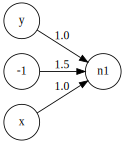

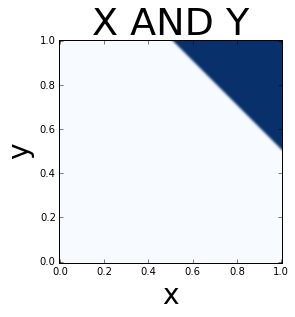

In [5]:
#Firstly, we want to specify the  3 inputs: x, y, and the -1 for the thresholding trick. 
inputs = ['x', 'y', -1]

#We then need to specify the neurons we want in the network by providing a list of string identifiers.
#In this case, we only need one neuron. 
neurons = ['n1']

#We also want to specify which neuron is the output neuron. Again, since we are only using one neuron, 
#n1 is also our output neuron. 
output_neuron = 'n1'

#The next step is to wire the net. We make connections in the following format:
#(input, neuron, weight_on_input )
#Note that if you wanted to connect two neurons together, you could have:
#('nx', 'ny', 1.0)

#We want all 3 inputs to connect to our single neuron. x and y are weighted by 1 and -1 is weighted by 1.5, the threshold
connections = [('x', 'n1',  1),
               ('y', 'n1',  1),
               (-1, 'n1', 1.5)]

#Finally we can initialize our net like so:
and_net = NN(inputs, neurons, output_neuron, connections)
#To visualize your neural network, run:
and_net.graph()

#To plot the decision boundaries drawn, call:
plot_net(and_net, 'X AND Y', step)

#The last argument is the activation function. We are using the step function, 
#but you can also use the provided sigmoid function - plot_net(and_net, 'X AND Y', sigmoid)
# 'X AND Y' is the title string

#NOTE: This will not run until you have completed forward propagation.




## Forward Propagation

Now that you're familiar with how the API creates a neural net, its time to complete one of the missing functions!

You will now implement the process of Forward Propagation. This process is essentially "running" the network. For each neuron, we must take the inputs, perform the weighted sum, and run the activation function. We start with the neurons in the input layer and work through the network until we can calculate the final output. 

Use the existing functions in the API (the topological sort might be of particular usefulness) to program forward propagation below.

In [6]:
# perform forward propogation on the neural net, returning the overall output and a dictionary of each neuron's output
def myForwardProp(neuralNet, input_value_dict, threshold_function):
    # neuralNet is the Neural Net Class Instance
    # input_value_dict is a copy of the input dictionary, mapping input variables to values
    #raise NotImplementedError
    
    for neuron in neuralNet.top_sorted_neurons:
      neuralNet.neurons[neuron].call(input_value_dict, threshold_function)
    return input_value_dict[neuralNet.output_neuron], input_value_dict


You can run the following code to test your implementation of forward propagation. All the logical operator plots will also use this code, so you can use those results as additional test cases.

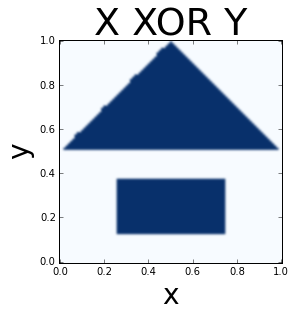

Tests passed!!

In [7]:
# triangle and rectangle
inputs = ['x', 'y', -1]
neurons = ['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10']
output_neuron = 'n10'
connections = [('x', 'n1', -1),
               ('y', 'n1', -1),
               ( -1, 'n1', -1.5),
               ('x', 'n2', 1),
               ('y', 'n2', -1),
               ( -1, 'n2', -.5),
               ('x', 'n3', 0),
               ('y', 'n3', 1),
               ( -1, 'n3', .5),
               ('n1', 'n4', 1),
               ('n2', 'n4', 1),
               ('n3', 'n4', 1),
               ( -1, 'n4',  2.5),
               ('x', 'n5', -1),
               ( -1, 'n5', -.75),
               ('x', 'n6', 1),
               ( -1, 'n6', .25),
               ('y', 'n7', -1),
               ( -1, 'n7', -.375),
               ('y', 'n8', 1),
               ( -1, 'n8', .125),
               ('n5', 'n9', 1),
               ('n6', 'n9', 1),
               ('n7', 'n9', 1),
               ('n8', 'n9', 1),
               ( -1, 'n9',  3.5),
               ('n4', 'n10', 1),
               ('n9', 'n10', 1),
               ( -1, 'n10',  .5)]
xor_net = NN(inputs, neurons, output_neuron, connections)
plot_net(xor_net, 'X XOR Y', step)
#xor_net.graph()

# verify forward prop
dict = {'x':1, 'y':1}
checks = [((.5,.75), 1), 
          ((.5,.45), 0), 
          ((.5,.25), 1), 
          ((.5,.08), 0), 
          ((.1,.75), 0), 
          ((.9,.75), 0), 
          ((.1,.25), 0), 
          ((.9,.25), 0)]
for ((x,y), out) in checks:
    dict['x'] = x
    dict['y'] = y
    net_output = myForwardProp(xor_net,dict, step)[0]
    if net_output != out:
      raise Exception('Failed on (' + str(x) + ', ' + str(y) + '): ' + str(out) + ', output was: ' + str(net_output))
test_ok()

## Logical Operators

Now that you've completed the forward propagation, the AND neuron we built earlier can be run. 

You will now create the neurons for OR and NOT(x)

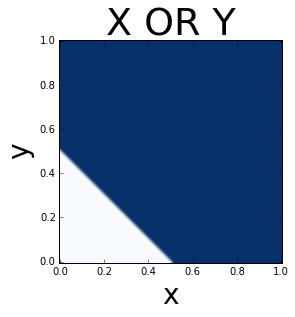

In [8]:
#define necessary aspects here


#confirm your answer by checking the resulting plot

#or_net = NN(inputs, neurons, output_neuron, connections)
#or_net.graph()
#plot_net(or_net, 'X OR Y', step)

inputs = ['x', 'y', .5]
neurons = ['n1']
output_neuron = 'n1'
connections = [('x', 'n1',  1),
               ('y', 'n1',  1),
               (.5 , 'n1', -1)]
or_net = NN(inputs, neurons, output_neuron, connections)
plot_net(or_net, 'X OR Y', step)


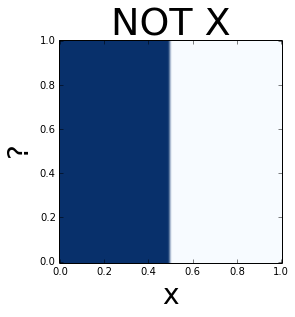

In [10]:
#define necessary aspects here


#confirm your answer by checking the resulting plot

#notX_net = NN(inputs, neurons, output_neuron, connections)
#notX_net.graph()
#plot_net(notX_net, 'NOT X', step)

inputs = ['x', .5]
neurons = ['n1']
output_neuron = 'n1'
connections = [('x', 'n1', -1),
               (.5 , 'n1',  1)]
not_net = NN(inputs, neurons, output_neuron, connections)
plot_net(not_net, 'NOT X', step)

## XOR

Now you will implement XOR, but this operator is a little more complicated than the previous ones.

You will need to draw two decision boundaries and combine them using one of the other logical operations. 

As we talked about before, this means that implementing XOR will require more than one neuron. 

<img src="xor.png" width="200" height=auto>


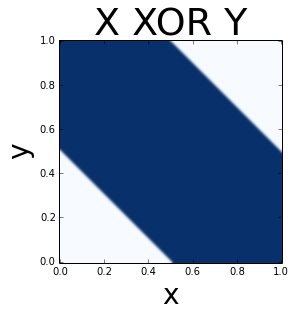

In [14]:
#define necessary aspects here


#confirm your answer by checking the resulting plot

#xor_net = NN(inputs, neurons, output_neuron, connections)
#xor_net.graph()
#plot_net(xor_net, 'X XOR Y', step)

inputs = ['x', 'y', 1.5, .5]
neurons = ['n1', 'n2', 'n3']
output_neuron = 'n3'
connections = [('x', 'n1', -1),
               ('y', 'n1', -1),
               (1.5, 'n1',  1),
               ('x', 'n2',  1),
               ('y', 'n2',  1),
               (.5 , 'n2', -1),
               ('n1', 'n3',  1),
               ('n2', 'n3',  1),
               (1.5 , 'n3', -1)]
xor_net = NN(inputs, neurons, output_neuron, connections)
#xor_net.graph()
plot_net(xor_net, 'X XOR Y', step)


## Backpropagation

Lastly, you will implement backpropagation using the sigmoid function as the activation function. 


The sigmoid function has some nice mathematical properties, so calculating the weights using the procedure described in lecture results in a simple formula, which we have computed for you. 

<img src="equations.png" width="700" height=auto>

To run backpropagation, you will:

 1. Run forward propagation and save the outputs of every neuron
 2. Compute the delta value for each neuron, starting from the output neuron and working backwards, towards the input neurons
 3. Calculate the new weights using the delta values and update them in the network.
 
 




In [15]:
#For the following functions:

# neuralNet is a Neural Net Class Instance
# input_value_dict is an input dictionary, mapping input variables to values
# output_dict needs to be a mapping every neuron in the network to its output

# Helper Function for backward_prop- returns a dictionary of deltas, one for each neuron in the network
def compute_deltas(neuralNet, input_value_dict, output_dict, desired_out):
    #raise NotImplementedError
    out = output_dict[neuralNet.output_neuron]
    deltas = {neuralNet.output_neuron:out * (1 - out) * (desired_out - out)}
    for neuron in reversed(neuralNet.top_sorted_neurons[:-1]):
      deltas[neuron] = output_dict[neuron] * (1 - output_dict[neuron]) * \
    sum([neuralNet.neurons[out_neuron].get_weight(neuron) * deltas[out_neuron] for out_neuron in neuralNet.get_output_connections(neuron)])
    return deltas

# Helper Function for backward_prop- updates all of the weights in the network, doesn't return anything
def update_weights(neuralNet, input_value_dict, output_dict, desired_out, r):
    #raise NotImplementedError
    deltas = compute_deltas(neuralNet,input_value_dict, output_dict, desired_out)
    for neuron in neuralNet.neurons.values():
      for input in neuron.neuron_inputs:
        neuron.update_weight(input, neuron.get_weight(input) + deltas[neuron.name] * r * output_dict[input])
    
    
# Perform backward propogation on the neural net, and changes the weights in the network - it doesn't return anything
def myBackwardProp(neuralNet, input_value_dict, desired_out, threshold_function=sigmoid, r=1, max_error=-.0001):
    #raise NotImplementedError
    out, output_dict = myForwardProp(neuralNet,input_value_dict, threshold_function)
    while (accuracy(desired_out, out) < max_error):
      update_weights(neuralNet,input_value_dict, output_dict, desired_out, r)
      out, output_dict = myForwardProp(neuralNet,input_value_dict, threshold_function)

    

    
    
    

You can use the following code to test your implementation.

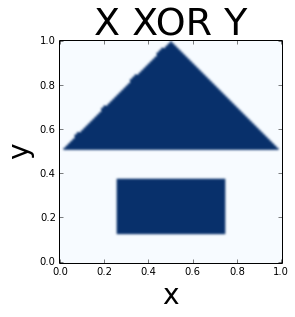

Tests passed!!

In [16]:
# triangle and rectangle
inputs = ['x', 'y', -1]
neurons = ['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10']
output_neuron = 'n10'
connections = [('x', 'n1', -1),
               ('y', 'n1', -1),
               ( -1, 'n1', -1.5),
               ('x', 'n2', 1),
               ('y', 'n2', -1),
               ( -1, 'n2', -.5),
               ('x', 'n3', 0),
               ('y', 'n3', 1),
               ( -1, 'n3', .5),
               ('n1', 'n4', 1),
               ('n2', 'n4', 1),
               ('n3', 'n4', 1),
               ( -1, 'n4',  2.5),
               ('x', 'n5', -1),
               ( -1, 'n5', -.75),
               ('x', 'n6', 1),
               ( -1, 'n6', .25),
               ('y', 'n7', -1),
               ( -1, 'n7', -.375),
               ('y', 'n8', 1),
               ( -1, 'n8', .125),
               ('n5', 'n9', 1),
               ('n6', 'n9', 1),
               ('n7', 'n9', 1),
               ('n8', 'n9', 1),
               ( -1, 'n9',  3.5),
               ('n4', 'n10', 1),
               ('n9', 'n10', 1),
               ( -1, 'n10',  .5)]
xor_net = NN(inputs, neurons, output_neuron, connections)
plot_net(xor_net, 'X XOR Y', step)
# xor_net.graph()

# verify backward prop
input_value_dict = {'x':.5, 'y':.45}
desired_out = 1
checks = [('n10', 'n9', 1.0580876267998136),
          ('n10', 'n4', 1.750519436878936),
          ('n10', -1, 0.5),
          ('n8', 'y', 1.004405571242847),
          ('n8', -1, 0.125),
          ('n9', 'n8', 1.0448828563571808),
          ('n9', -1, 3.5),
          ('n9', 'n5', 1.0417815987312213),
          ('n9', 'n6', 1.0417815987312213),
          ('n9', 'n7', 1.024362381541987),
          ('n1', 'y', -0.9842872685460131),
          ('n1', 'x', -0.9825414094955703),
          ('n1', -1, -1.5),
          ('n2', 'y', -0.9842872685460131),
          ('n2', 'x', 1.0174585905044304),
          ('n2', -1, -0.5),
          ('n3', 'y', 1.0418161693022556),
          ('n3', 'x', 0.04646241033584111),
          ('n3', -1, 0.5),
          ('n4', 'n1', 1.3130856737676413),
          ('n4', 'n2', 1.3130856737676413),
          ('n4', 'n3', 1.162829074164861),
          ('n4', -1, 2.5),
          ('n5', 'x', -0.9942918288280811),
          ('n5', -1, -0.75),
          ('n6', 'x', 1.005708171171915),
          ('n6', -1, 0.25),
          ('n7', 'y', -0.993643573887871),
          ('n7', -1, -0.375)]

myBackwardProp(xor_net,input_value_dict, desired_out)
for (neuron_name, input, weight) in checks:
  weight_out = xor_net.neurons[neuron_name].weight_dict[input]
  if abs(weight_out - weight) > .001:
    raise Exception('Failed on ' + str(neuron_name) + ' with input ' + str(input) + ' and weight ' + str(weight) + ', weight was: ' + str(weight_out))
test_ok()

## Congrats! 

You are done with Part 1 of the Pset!